### Walmart Sales Forecasting

Source: https://www.kaggle.com/c/m5-forecasting-accuracy/overview

<b>Problem Statement</b>: Using hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. As these forecasting may lead to provide supply of right product at right store at right time, keeping balance in inventory levels and this can lead to increase in revenue. 

The dataset, covers the sales of stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. 

#### Why Machine learning
* Machine learning methods outperforms statistical methods (according to conclusion of https://github.com/Mcompetitions/M5-methods/blob/master/M5_accuracy_competition.pdf)
* Using feature engineering we can add other useful information like (prices,dates,events,lags,rolling) features on our data whereas the statistical methods only use historical sales data. 

#### Performance metric
The accuracy of the point forecasts will be evaluated using the Root Mean Squared Scaled Error (RMSSE), which is a variant of the well-known Mean Absolute Scaled Error (MASE).The measure is calculated for each series as follows:
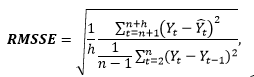
* The measure is scale independent, meaning that it can be effectively used to compare forecasts across series with different scales. 
* The measure penalizes positive and negative forecast errors, as well as large and small forecasts, equally, thus being symmetric.

Source:https://github.com/Mcompetitions/M5-methods/blob/master/M5_accuracy_competition.pdf

The Objective of this notebook is to get insights about data (EDA), preprocess it's features and get data ready for modelling. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from downcast import reduce
import calmap
import warnings
from plotly.io import to_image
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# sales = pd.read_pickle('sales_ad.pkl')
# cal = pd.read_pickle('cal_ad.pkl')
# prices = pd.read_pickle('prices_ad.pkl')

In [3]:
#Data overview
#There are 3 data training files as follows:

sales = pd.read_csv("sales_train_validation.csv")
prices = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

print("Shape of sales:",sales.shape)
print("Shape of prices:",prices.shape)
print("Shape of cal:",cal.shape)

Shape of sales: (30490, 1919)
Shape of prices: (6841121, 4)
Shape of cal: (1969, 14)


In [3]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [4]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [5]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


* sales: It includes all id's of item regarding category, depaetment, store, state and a sales column for each day from 2011-01-29 to 2016-04-24 (1913 days).
* prices: It has prices of items as a weekly average
* cal: It has date features, four event features showing whether there was event at that date or not and three snap features for whether that day had snap in some state or not.

In [6]:
#Basic info about data

print('No of unique items in a store:',len(sales['item_id'].unique()))
print('No of Deptartments:',len(sales['dept_id'].unique()))
print('No of Categories:',len(sales['cat_id'].unique()))
print('Total Stores:',len(sales['store_id'].unique()))
print('States:',len(sales['state_id'].unique()))

No of unique items in a store: 3049
No of Deptartments: 7
No of Categories: 3
Total Stores: 10
States: 3


* The states are  CA, TX and WI.
* The stores are CA_1, CA_2, CA_3, CA_4(CA), TX_1,TX_2, TX_3(TX) and W1_1, WI_2, WI_3(WI).
* The Categories are FOODS, HOUSEHOLD and HOBBIES.
* The Departments are FOODS_1, FOODS_2, FOODS_3(FOODS), HOUSEHOLD_1, HOUSEHOLD_2(HOUSEHOLD) AND HOBBIES_1, HOBBIES_2(HOBBIES).

###  Overview of Dataset

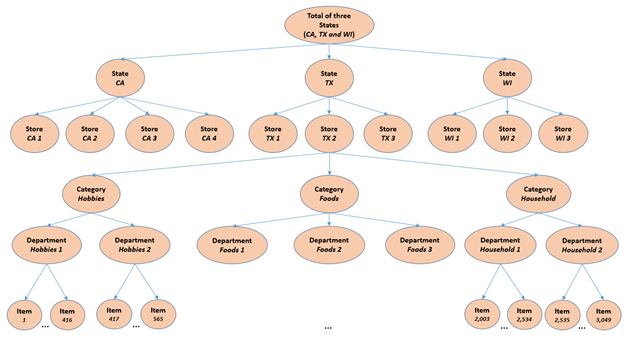

#### Downcasting
Downcasting reduces the size of dataframes. Basically what it does is for each (int/float) column it checks its min and max values and assign a data type with a lowest storage capacity for that column and for categorical features it changes it's data type from object to category. 

In [6]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_bd = np.round(cal.memory_usage().sum()/(1024*1024),1)

sales = pd.read_pickle("sales_ad.pkl")
prices = pd.read_pickle("prices_ad.pkl")
cal = pd.read_pickle("cal_ad.pkl")

sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_ad = np.round(cal.memory_usage().sum()/(1024*1024),1)

In [4]:

#Getting file size in MB before downcasting
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_bd = np.round(cal.memory_usage().sum()/(1024*1024),1)

#Downcasting the dataframes
sales = reduce(sales)
prices = reduce(prices)
cal = reduce(cal)

#Getting size after Downcasting
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)
cal_ad = np.round(cal.memory_usage().sum()/(1024*1024),1)


In [7]:
print("The size of sales (in MB) before/after downcasting: ",sales_bd,'/',sales_ad)
print("The size of prices (in MB) before/after downcasting: ",prices_bd,'/',prices_ad)
print("The size of cal (in MB) before/after downcasting: ",cal_bd,'/',cal_ad)

The size of sales (in MB) before/after downcasting:  446.4 / 94.1
The size of prices (in MB) before/after downcasting:  208.8 / 45.7
The size of cal (in MB) before/after downcasting:  0.2 / 0.1


In [18]:
dic = {'DataFrame':['sales','prices','cal'],
       'Before downcasting':[sales_bd,prices_bd,cal_bd],
       'After downcasting':[sales_ad,prices_ad,cal_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
#fig.show()
img_bytes = fig.to_image(format="png")

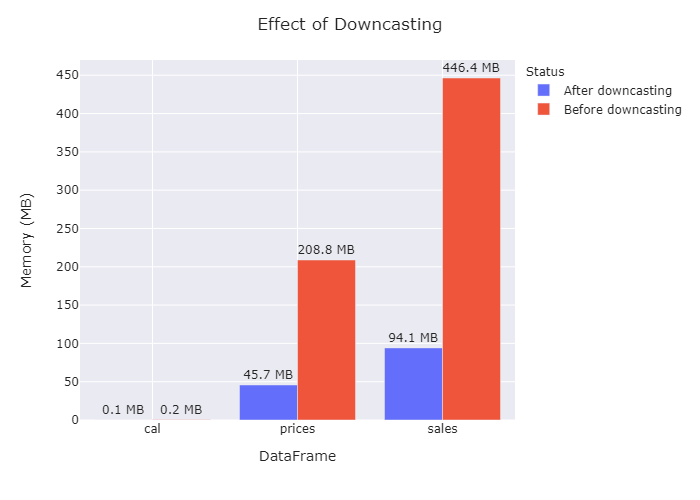

In [19]:
Image(img_bytes)

* Among all three dataframes sales got reduced the most maybe because of the 1913 int columns got reduced to it's lowest datatype

## EDA

### EDA of Sales Data

#### All Aggregated Sales

Plotting the aggregate time series over all items, stores, categories, departments and sales.

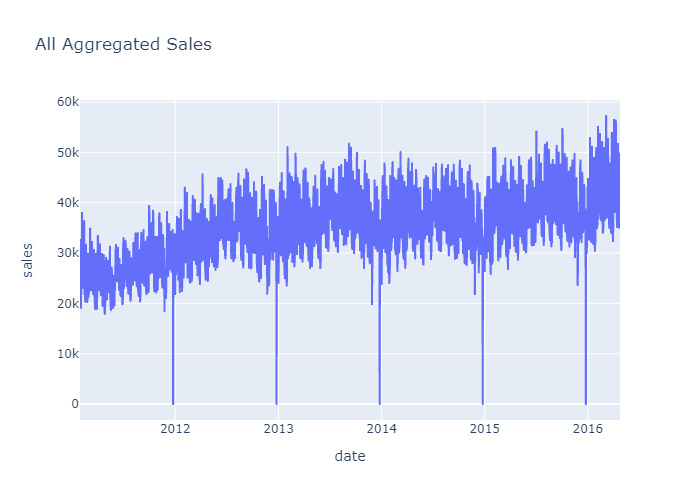

In [20]:
d_cols = [i for i in sales.columns if 'd_' in i]

sales_df = sales[d_cols]

total_sales = list(sales_df.sum(axis = 0)) 

date_list = [d for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]
agg_sales = pd.DataFrame({'date' : date_list,'sales' : total_sales})

fig = px.line(agg_sales, x='date', y='sales', title = 'All Aggregated Sales')

for ser in fig['data']:
    ser['text']= [d.strftime('%Y-%m-%d') for d in agg_sales['date']]
    ser['hovertemplate']='dates=%{text}<br>price=%{y}'

#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* After some decline in sales in 2011 an upward trend is observed
* Zero sales is observed in each year that is christmas (2011-12-25).
* After Zooming, a weekly seasonality is also observed.
* Comparing to all years, little faster growth is observed in 2016.

#### Monthly Aggregated sales per state

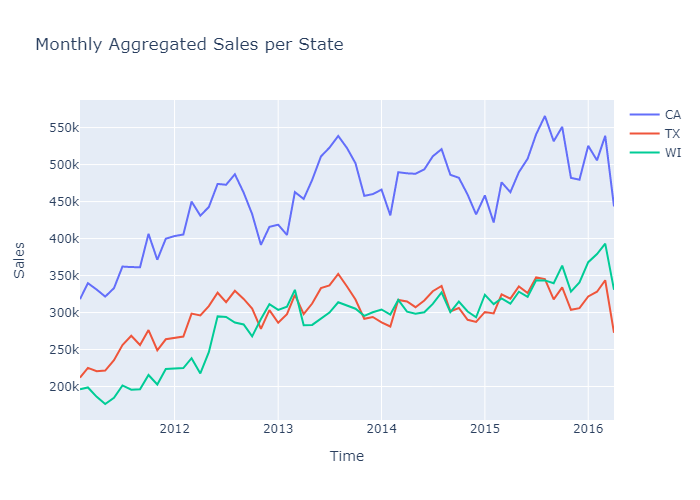

In [21]:
sales_df = sales.groupby(['state_id'])[d_cols].sum()

date_list = [(d.year*100)+d.month for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

agg_sales = pd.DataFrame({'date' : date_list, 'CA_sales' : sales_df.iloc[0], 'TX_sales' : sales_df.iloc[1], 'WI_sales' : sales_df.iloc[2]})
monthly_agg = agg_sales.groupby('date').sum()
monthly_agg = monthly_agg.iloc[1:]

monthly_dates = [d for d in pd.date_range(start = '2011-01-29', end = '2016-04-24', freq = 'MS')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_dates, y= monthly_agg['CA_sales'],
                    mode='lines',
                    name='CA'))
fig.add_trace(go.Scatter(x=monthly_dates, y=monthly_agg['TX_sales'],
                    mode='lines',
                    name='TX'))
fig.add_trace(go.Scatter(x=monthly_dates, y=monthly_agg['WI_sales'],
                    mode='lines', name='WI'))

fig.update_layout(title='Monthly Aggregated Sales per State',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* Comparing to other states California(CA) sales performed better, while sales of Texas(TX) and Wisconsin(WI) found to be intersecting with each other, ending up with a raise in Wisconsin(WI).
* Mostly the raise in sales in a year was observed in pre-Autumn months (Aug-Oct)
* In 2014-15 a dip was observed in sales, which was severe in CA and slightly less in other two.

#### Overall Sales per store

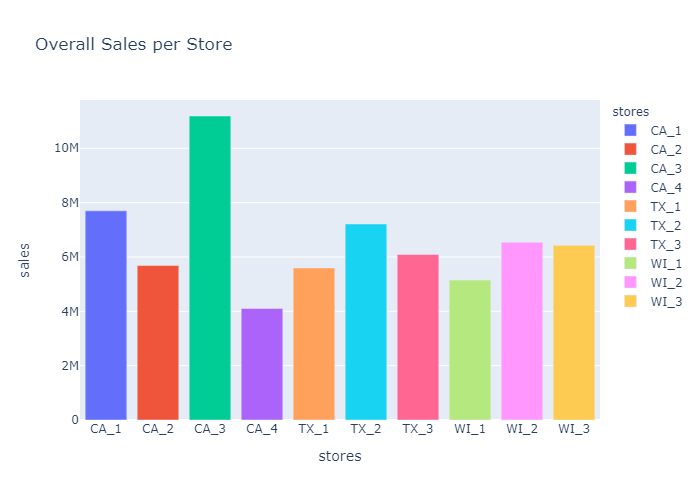

In [22]:
d_cols = [i for i in sales.columns if 'd_' in i]
sales_df = sales.groupby(['store_id'])[d_cols].sum()
store_sales = sales_df.sum(axis = 1)
bar_plot = pd.DataFrame({'stores':store_sales.index, 'sales':store_sales.values})
fig = px.bar(bar_plot, x='stores', y='sales', color = 'stores', title = 'Overall Sales per Store')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* The CA_3 store have the highest sales whereas CA_4 have the lowest
* Stores in Texas(TX) and Winsconsin(WI) have similar sales among their corresponding state stores.

#### Sales of Stores in CA State

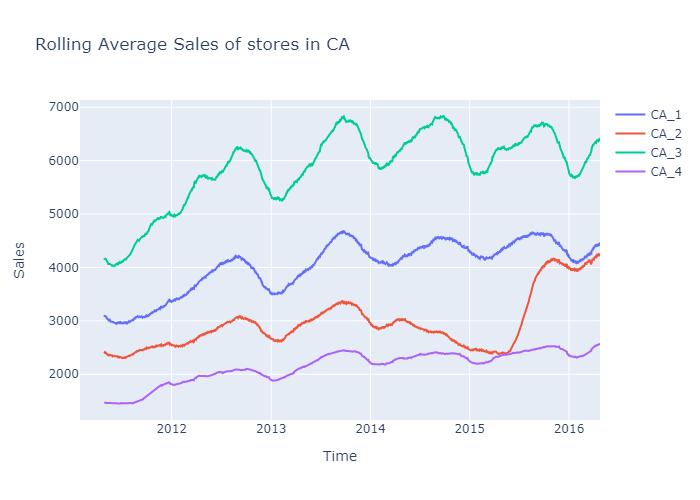

In [23]:
dates = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

past_sales = sales.set_index('id')[d_cols].T

cols = ['CA_1','CA_2','CA_3','CA_4']

fig = go.Figure()
for s in cols:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=dates, y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales of stores in CA")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* In California(CA) the store CA_1 has the highest sales and Ca_4 has the lowest
* There is almost similar trend observed in all stores of california, except CA_2 store. From mid of 2014 the sales of CA_2 has started decline and met with CA_4  in mid 2015 and then had sudden increase and followed CA_1 trend.

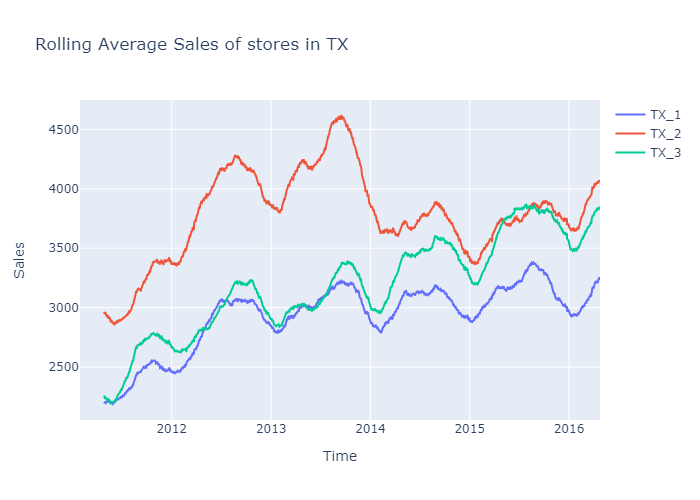

In [24]:
#Sales of stores in TX
cols = ['TX_1','TX_2','TX_3']

fig = go.Figure()
for s in cols:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=dates, y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales of stores in TX")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* In Texas the TX_2 have highest sales and TX_1 have lowest
* The sales of TX_1 and TX_2 follows similar trend while the sales of TX_3 often intersects with TX_1 for the starting years (2011-13) and with TX_2 for ending years(2015-16). 

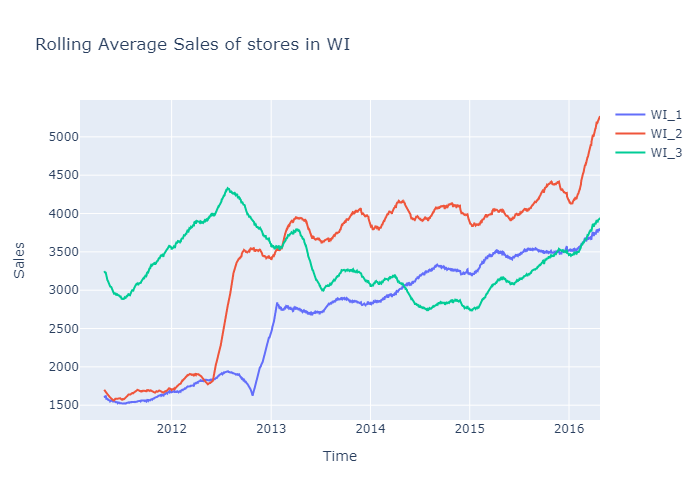

In [25]:
#Sales of stores in WI
cols = ['WI_1','WI_2','WI_3']

fig = go.Figure()
for s in cols:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=dates, y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales of stores in WI")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* No similar trend observed among the sales of stores of Wisconsin(WI).
* Store WI_3 had the highest sales for the starting years (2011-13) but decline in mid years(2013-14), started increasing in 2015.
* Store WI_1 and WI_2 have almost similar sales at beginning. The sales of WI_2 suddenly increased in mid of 2012 and followed an increasing trend, whereas WI_1 suddenly increased (not up to sales of WI_2) in end of 2012 and also followed an increasing trend further. 


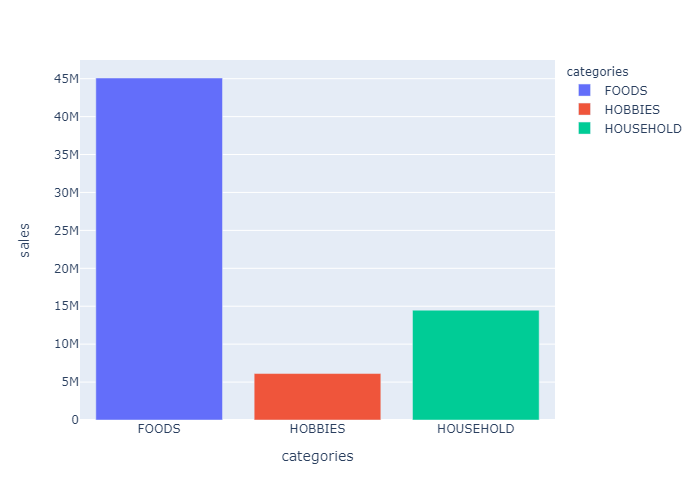

In [26]:
#Overall Sales Category wise

sales_df = sales.groupby(['cat_id'])[d_cols].sum()
cat_sales = sales_df.sum(axis = 1)
bar_plot = pd.DataFrame({'categories':cat_sales.index, 'sales':cat_sales.values})
fig = px.bar(bar_plot, x='categories', y='sales', color = 'categories')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

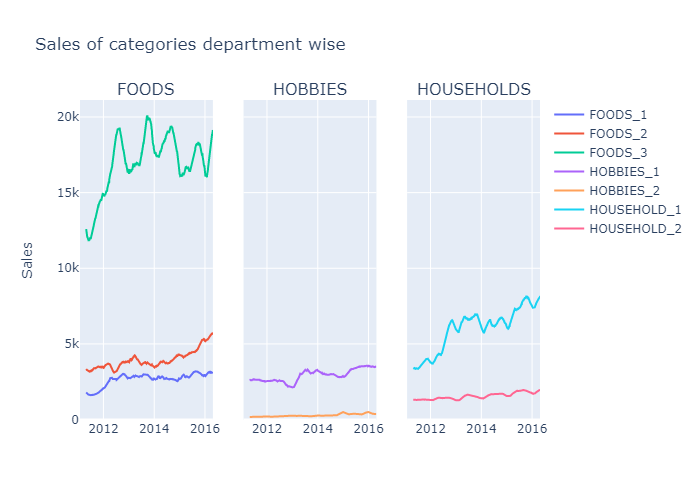

In [27]:
#Sales per categories

fig = make_subplots(rows = 1,cols = 3,subplot_titles=('FOODS', 'HOBBIES', 'HOUSEHOLDS'),shared_yaxes = True)

depts = [['FOODS_1','FOODS_2','FOODS_3'],['HOBBIES_1','HOBBIES_2'],['HOUSEHOLD_1','HOUSEHOLD_2']]

dates = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

past_sales = sales.set_index('id')[d_cols].T

for i in range(len(depts)):
    cols = depts[i]
    for s in cols:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Scatter(x=dates, y=data, name=s),row = 1,col = i+1)
    
fig.update_layout(yaxis_title="Sales", title = 'Sales of categories department wise')
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* FOODS is the most sold categoy followed by HOUSEHOLD and HOBBIES. It is obvious that people will need essential items the most than other things.
* FOODS_3 is driving the sales of FOOD Category,while FOODS_2 is little picking up at the end.
* HOUSEHOLD_1 tends to follow an increasing trend while the other three (HOOBIES_1,HOBBIES_2, HOUSEHOLD_2) seems to be settled at the same range of sales.

### EDA on Calendar data 

In [19]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
cal = cal.fillna('No_Event')

In [4]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,No_Event,No_Event,No_Event,No_Event,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,No_Event,No_Event,No_Event,No_Event,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,No_Event,No_Event,No_Event,No_Event,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,No_Event,No_Event,No_Event,No_Event,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No_Event,No_Event,No_Event,No_Event,1,0,1


In [5]:
print('Total Events in a year:',len(cal['event_name_1'].unique())-1)
print('Different types of Events:',len(cal['event_type_1'].unique())-1,"they are",cal['event_type_1'].unique()[1:])

Total Events in a year: 30
Different types of Events: 4 they are ['Sporting' 'Cultural' 'National' 'Religious']


In [6]:
d_events = len(cal)-len(cal[cal['event_type_1'] == 'No_Event'])
print("Days with events:",d_events)
print(round((d_events/len(cal))*100,2),"% of days had events")

Days with events: 162
8.23 % of days had events


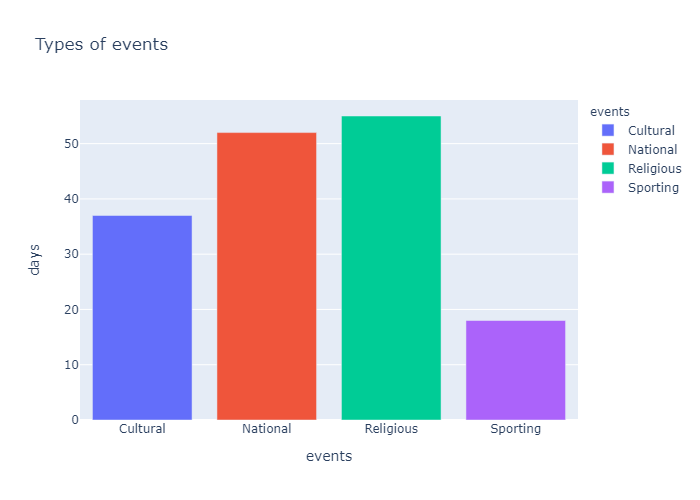

In [29]:
bar_plot = cal.groupby(['event_type_1']).agg(['count'])
bar_df = pd.DataFrame({'events':bar_plot.index,'days' : bar_plot[('date','count')]})
#bar_df = bar_df.drop(['No_Event'])
fig = px.bar(bar_df, x='events', y='days', color = 'events',title = 'Types of events')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

#### Plotting the snap days for each state for year 2012

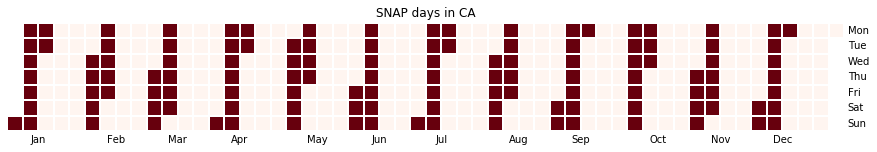

In [24]:
days = pd.date_range('1/29/2011', periods=1969, freq='D')

event1 = pd.Series(cal['snap_CA'].values,index = days)
event2 = pd.Series(cal['snap_TX'].values,index = days)
event3 = pd.Series(cal['snap_WI'].values,index = days)

f, ax = plt.subplots(1, 1, figsize = (15, 10))
calmap.yearplot(event1, dayticks = True,year=2012,ax = ax)
plt.title("SNAP days in CA")
plt.show()

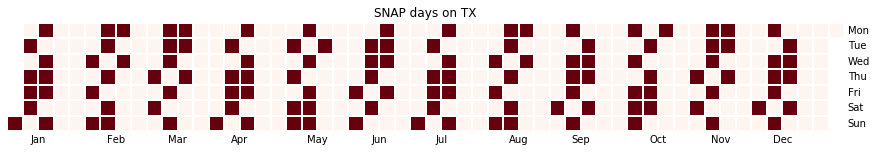

In [25]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
calmap.yearplot(event2, dayticks = True,year=2012,ax = ax)
plt.title("SNAP days on TX")
plt.show()

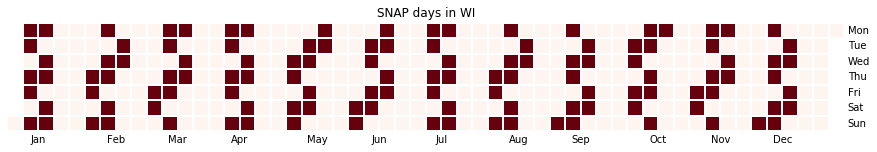

In [26]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
calmap.yearplot(event3, dayticks = True,year=2012,ax = ax)
plt.title("SNAP days in WI")
plt.show()

### Observations:
* Out of total days covered in data, 8% of the days have a special event. Of these events Religious and National events are the most events.
* Almost 30% of the days had the sales of items with SNAP food stamps. In CA state the first 10 days of months are SNAP days. In TX state the SNAP days follows the code 101011 and in WI SNAP days follows 011 code.All the SNAP days are in the first 15 days of the months.Thus making it the 30% of the data. 

In [41]:
cal = pd.read_csv('calendar.csv')
cal = cal.fillna('No_Event')

### Sales on  Events vs Non_events

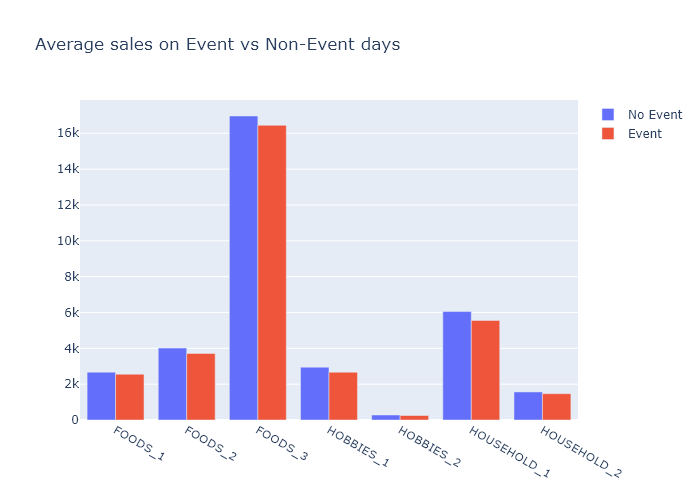

In [43]:
cal = cal.iloc[:1913]
d_no_event = list(cal[cal['event_type_1'] == 'No_Event']['d'])
d_event = list(cal[cal['event_type_1'] != 'No_Event']['d'])

sales_df = sales.groupby(['dept_id']).sum()

no_mean = []
eve_mean = []

depts = ['FOODS_1','FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']

for i in range(len(depts)):
    no_mean.append(sales_df[d_no_event].iloc[i].mean())
    eve_mean.append(sales_df[d_event].iloc[i].mean())

fig = go.Figure(data=[
    go.Bar(name='No Event', x=depts, y = no_mean),
    go.Bar(name='Event', x=depts, y = eve_mean)
])

fig.update_layout(barmode='group',title = 'Average sales on Event vs Non-Event days')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observation:
* Average sale on Non-Event day is slightly greater to average sale on event day for all categories

### Sales on Snap vs Non_snap days

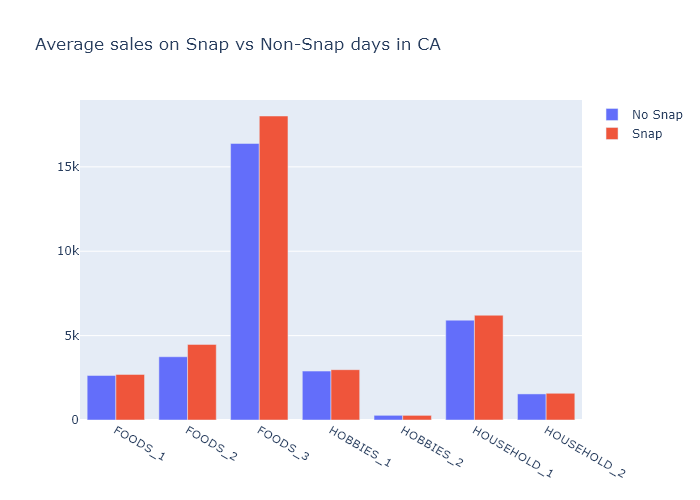

In [52]:
#For CA

d_no_snap = list(cal[cal['snap_CA'] == 0]['d'])
d_snap = list(cal[cal['snap_CA'] == 1]['d'])

no_mean = []
s_mean = []

for i in range(len(depts)):
    no_mean.append(sales_df[d_no_snap].iloc[i].mean())
    s_mean.append(sales_df[d_snap].iloc[i].mean())

fig = go.Figure(data=[
    go.Bar(name='No Snap', x=depts, y = no_mean),
    go.Bar(name='Snap', x=depts, y = s_mean)
])

fig.update_layout(barmode='group',title = 'Average sales on Snap vs Non-Snap days in CA')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

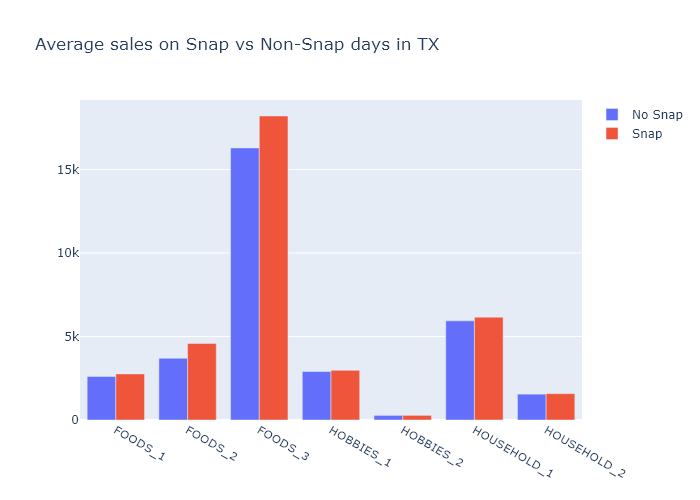

In [53]:
#For TX

d_no_snap = list(cal[cal['snap_TX'] == 0]['d'])
d_snap = list(cal[cal['snap_TX'] == 1]['d'])

no_mean = []
s_mean = []

for i in range(len(depts)):
    no_mean.append(sales_df[d_no_snap].iloc[i].mean())
    s_mean.append(sales_df[d_snap].iloc[i].mean())

fig = go.Figure(data=[
    go.Bar(name='No Snap', x=depts, y = no_mean),
    go.Bar(name='Snap', x=depts, y = s_mean)
])

fig.update_layout(barmode='group',title = 'Average sales on Snap vs Non-Snap days in TX')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

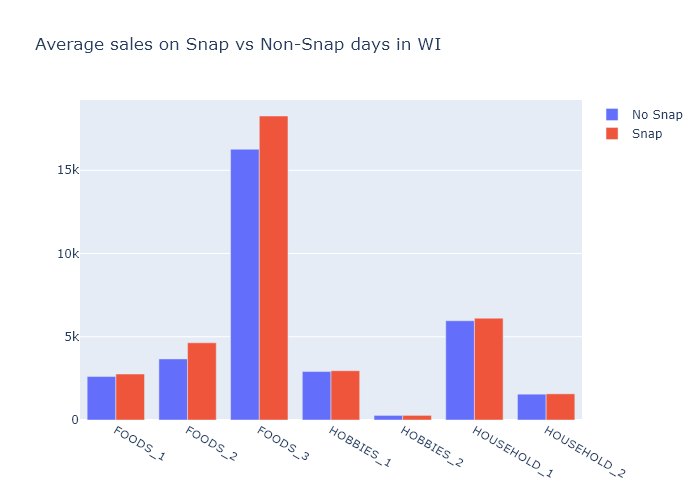

In [54]:
#For WI

d_no_snap = list(cal[cal['snap_WI'] == 0]['d'])
d_snap = list(cal[cal['snap_WI'] == 1]['d'])

no_mean = []
s_mean = []

for i in range(len(depts)):
    no_mean.append(sales_df[d_no_snap].iloc[i].mean())
    s_mean.append(sales_df[d_snap].iloc[i].mean())

fig = go.Figure(data=[
    go.Bar(name='No Snap', x=depts, y = no_mean),
    go.Bar(name='Snap', x=depts, y = s_mean)
])

fig.update_layout(barmode='group',title = 'Average sales on Snap vs Non-Snap days in WI')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* In all states the plot is same
* On snap days as the item prices are low the average sales are slighlty high than normal sales
* Among all the category FOODS_3 category have large difference between sales on snap and normal days.

### Weekly seasonality
Calulating overall sales of each state and aggregating the sales on each day of the week.

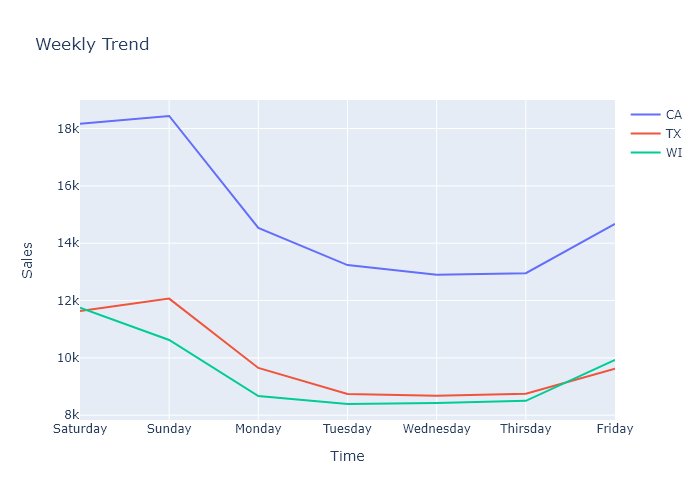

In [5]:
days = list(cal['wday'].iloc[:1913])
sales_df = sales.groupby(['state_id']).sum()

weekly_agg = pd.DataFrame({'weeks': days, 'CA' : sales_df.iloc[0], 'TX' : sales_df.iloc[1], 'WI' : sales_df.iloc[2]})
weekly_agg = weekly_agg.groupby(['weeks']).mean()
#weekly_agg.head()

fig = go.Figure()
fig.add_trace(go.Scatter(x=days, y= weekly_agg['CA'],
                    mode='lines',
                    name='CA'))
fig.add_trace(go.Scatter(x=days, y=weekly_agg['TX'],
                    mode='lines',
                    name='TX'))
fig.add_trace(go.Scatter(x=days, y=weekly_agg['WI'],
                    mode='lines', name='WI'))

fig.update_layout(title='Weekly Trend',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* Similar trend in three state with highest sales on weekends.

### Monthly Seasonality
Calulating overall sales of each state and aggregating the sales on each month of the year.

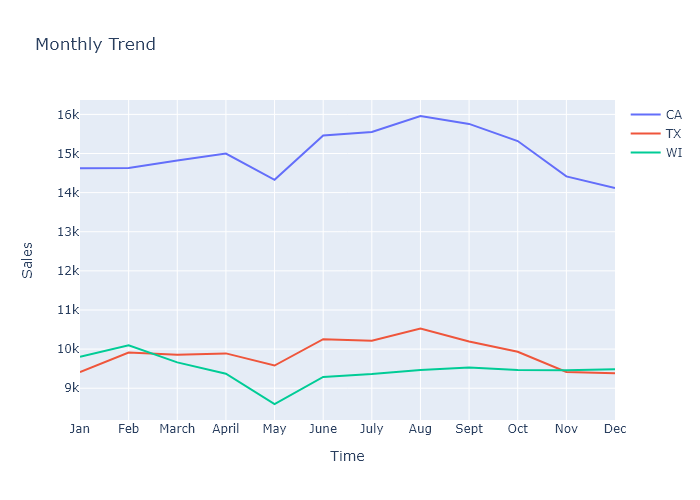

In [6]:
month_no = list(cal['month'].iloc[:1913])

monthly_agg = pd.DataFrame({'months': month_no, 'CA' : sales_df.iloc[0], 'TX' : sales_df.iloc[1], 'WI' : sales_df.iloc[2]})
monthly_agg = monthly_agg.groupby(['months']).mean()

months = ['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']

fig = go.Figure()
fig.add_trace(go.Scatter(x=months, y= monthly_agg['CA'],
                    mode='lines',
                    name='CA'))
fig.add_trace(go.Scatter(x=months, y=monthly_agg['TX'],
                    mode='lines',
                    name='TX'))
fig.add_trace(go.Scatter(x=months, y=monthly_agg['WI'],
                    mode='lines', name='WI'))

fig.update_layout(title='Monthly Trend',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* Highest sales in observed in March with slightly dips in month Nov and May.

### Weekly Seasonality by category and state

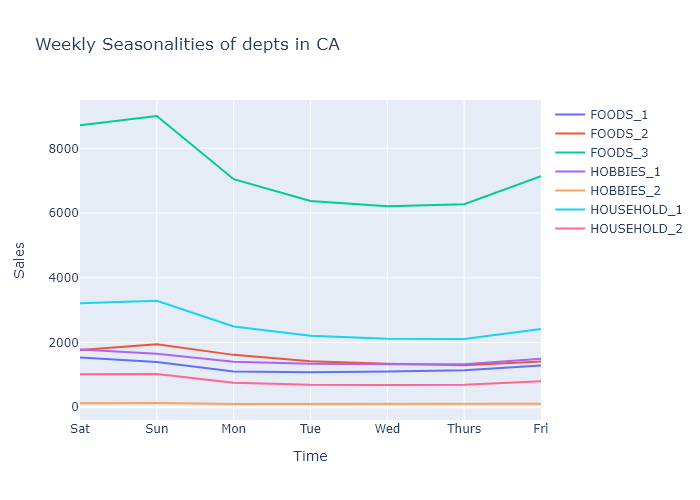

In [19]:
#For CA
days = list(cal['wday'].iloc[:1913])
sales_df = sales[sales['state_id'] == 'CA'].groupby(['dept_id']).sum()

w_seas = pd.DataFrame({'days': days, 'FOODS_1' : sales_df.iloc[0], 'FOODS_2' : sales_df.iloc[1], 'FOODS_3' : sales_df.iloc[2],
                           'HOBBIES_1' : sales_df.iloc[3], 'HOBBIES_2' : sales_df.iloc[4], 'HOUSEHOLD_1' : sales_df.iloc[5],
                           'HOUSEHOLD_2' : sales_df.iloc[6] })
w_seas = w_seas.groupby(['days']).mean()
w_seas['days'] =  ['Sat','Sun','Mon','Tue','Wed','Thurs','Fri']

depts = ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2']

fig = go.Figure()
for i in depts:
    fig.add_trace(go.Scatter(x= w_seas['days'], y= w_seas[i],
                    mode='lines',
                    name=i))

fig.update_layout(title='Weekly Seasonalities of depts in CA',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

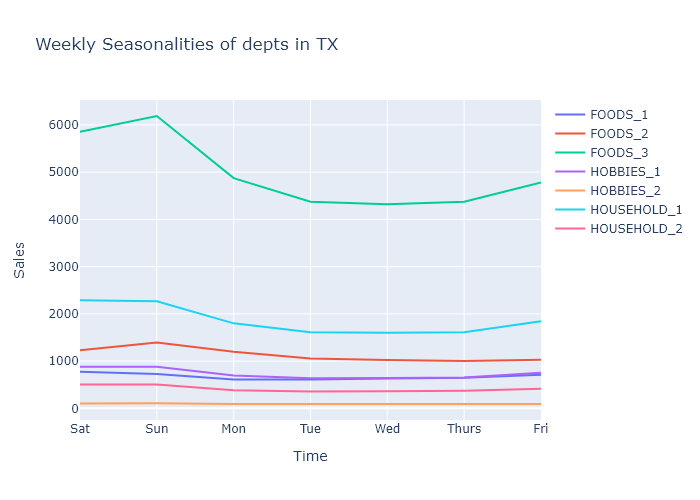

In [21]:
sales_df = sales[sales['state_id'] == 'TX'].groupby(['dept_id']).sum()

w_seas = pd.DataFrame({'days': days, 'FOODS_1' : sales_df.iloc[0], 'FOODS_2' : sales_df.iloc[1], 'FOODS_3' : sales_df.iloc[2],
                           'HOBBIES_1' : sales_df.iloc[3], 'HOBBIES_2' : sales_df.iloc[4], 'HOUSEHOLD_1' : sales_df.iloc[5],
                           'HOUSEHOLD_2' : sales_df.iloc[6] })
w_seas = w_seas.groupby(['days']).mean()
w_seas['days'] =  ['Sat','Sun','Mon','Tue','Wed','Thurs','Fri']

depts = ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2']

fig = go.Figure()
for i in depts:
    fig.add_trace(go.Scatter(x= w_seas['days'], y= w_seas[i],
                    mode='lines',
                    name=i))

fig.update_layout(title='Weekly Seasonalities of depts in TX',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

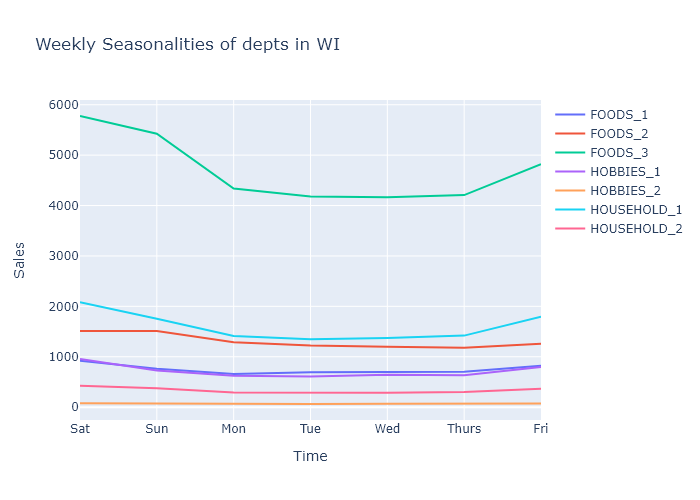

In [22]:
sales_df = sales[sales['state_id'] == 'WI'].groupby(['dept_id']).sum()

w_seas = pd.DataFrame({'days': days, 'FOODS_1' : sales_df.iloc[0], 'FOODS_2' : sales_df.iloc[1], 'FOODS_3' : sales_df.iloc[2],
                           'HOBBIES_1' : sales_df.iloc[3], 'HOBBIES_2' : sales_df.iloc[4], 'HOUSEHOLD_1' : sales_df.iloc[5],
                           'HOUSEHOLD_2' : sales_df.iloc[6] })
w_seas = w_seas.groupby(['days']).mean()
w_seas['days'] =  ['Sat','Sun','Mon','Tue','Wed','Thurs','Fri']

depts = ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2']

fig = go.Figure()
for i in depts:
    fig.add_trace(go.Scatter(x= w_seas['days'], y= w_seas[i],
                    mode='lines',
                    name=i))

fig.update_layout(title='Weekly Seasonalities of depts in WI',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Monthly Seasonality by category and state

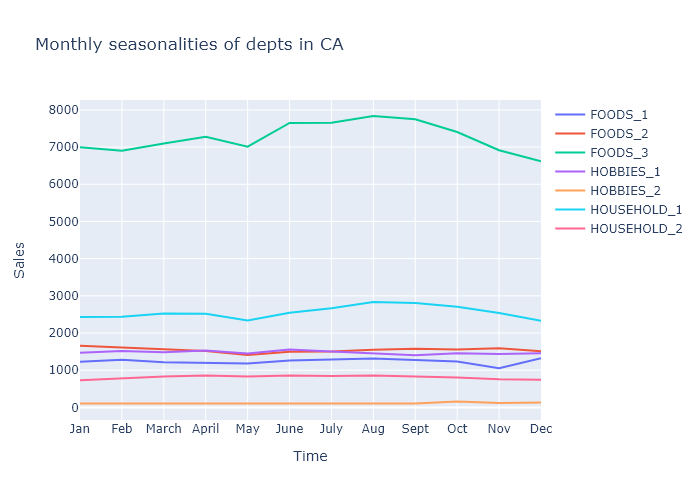

In [23]:
months = ['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
month_no = list(cal['month'].iloc[:1913])

sales_df = sales[sales['state_id'] == 'CA'].groupby(['dept_id']).sum()

m_seas = pd.DataFrame({'months': month_no, 'FOODS_1' : sales_df.iloc[0], 'FOODS_2' : sales_df.iloc[1], 'FOODS_3' : sales_df.iloc[2],
                           'HOBBIES_1' : sales_df.iloc[3], 'HOBBIES_2' : sales_df.iloc[4], 'HOUSEHOLD_1' : sales_df.iloc[5],
                           'HOUSEHOLD_2' : sales_df.iloc[6] })
m_seas = m_seas.groupby(['months']).mean()

depts = ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2']

fig = go.Figure()
for i in depts:
    fig.add_trace(go.Scatter(x= months, y= m_seas[i],
                    mode='lines',
                    name=i))

fig.update_layout(title='Monthly seasonalities of depts in CA',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

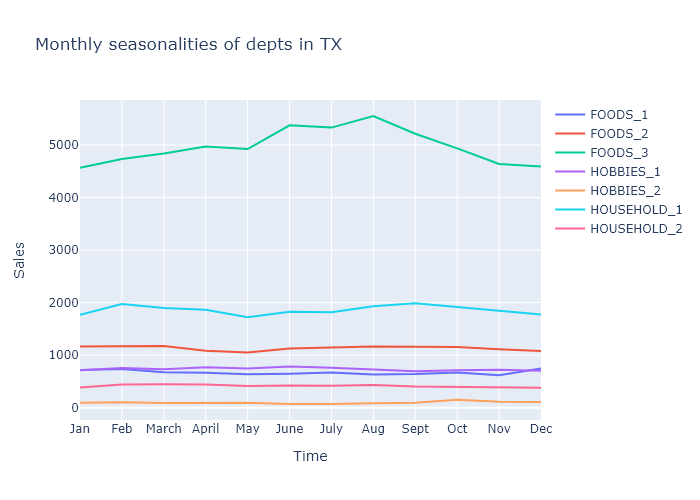

In [24]:
sales_df = sales[sales['state_id'] == 'TX'].groupby(['dept_id']).sum()

m_seas = pd.DataFrame({'months': month_no, 'FOODS_1' : sales_df.iloc[0], 'FOODS_2' : sales_df.iloc[1], 'FOODS_3' : sales_df.iloc[2],
                           'HOBBIES_1' : sales_df.iloc[3], 'HOBBIES_2' : sales_df.iloc[4], 'HOUSEHOLD_1' : sales_df.iloc[5],
                           'HOUSEHOLD_2' : sales_df.iloc[6] })
m_seas = m_seas.groupby(['months']).mean()

fig = go.Figure()
for i in depts:
    fig.add_trace(go.Scatter(x= months, y= m_seas[i],
                    mode='lines',
                    name=i))

fig.update_layout(title='Monthly seasonalities of depts in TX',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

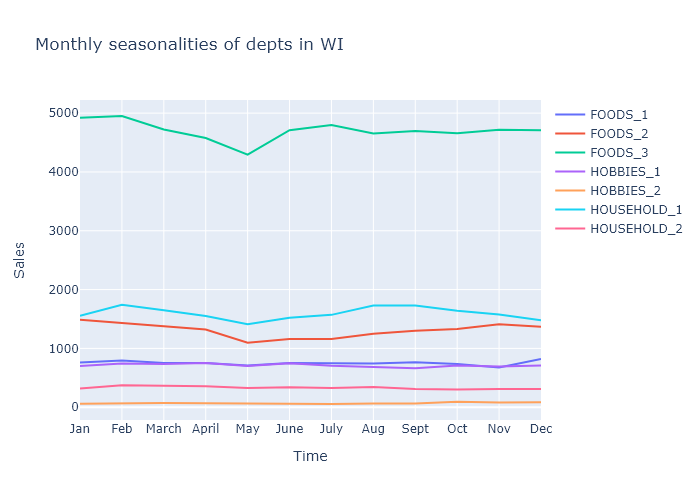

In [25]:
sales_df = sales[sales['state_id'] == 'WI'].groupby(['dept_id']).sum()

m_seas = pd.DataFrame({'months': month_no, 'FOODS_1' : sales_df.iloc[0], 'FOODS_2' : sales_df.iloc[1], 'FOODS_3' : sales_df.iloc[2],
                           'HOBBIES_1' : sales_df.iloc[3], 'HOBBIES_2' : sales_df.iloc[4], 'HOUSEHOLD_1' : sales_df.iloc[5],
                           'HOUSEHOLD_2' : sales_df.iloc[6] })
m_seas = m_seas.groupby(['months']).mean()

fig = go.Figure()
for i in depts:
    fig.add_trace(go.Scatter(x= months, y= m_seas[i],
                    mode='lines',
                    name=i))

fig.update_layout(title='Monthly seasonalities of depts in WI',
                   xaxis_title='Time',
                   yaxis_title='Sales')
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Observations:
* Weekly trends for all states and categories were almost same.
* Sales ate weekends were most for all categories
* In states for all categories the dips were at month May
* In CA and TX the highest sales were observed in August
* In WI the sales weren't much deviating and were increasing in winter

There was not much changes in sales observed according to seasons and categories 

## Feature Engineering (FE)

In [31]:
sales_eval = pd.read_csv('sales_train_evaluation.csv')  
sales_eval = reduce(sales_eval)  #downcasting

#making test dataset, filling it with zero
for day in range(1942,1970):
    sales_eval['d_' + str(day)] = 0
    sales_eval['d_' + str(day)] = sales_eval['d_' + str(day)].astype(np.int16)

sales_eval.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Melting the data from wide form to long form
# i.e. converting all sales at date columns to row, for each row getting sales at that date
#for better understanding compare the above dataframe and below dataframe

data = pd.melt(sales_eval, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
          var_name='d', value_name='sales').dropna()
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [33]:
data = pd.merge(data, cal, on='d', how='left')
data = pd.merge(data, prices, on=['store_id','item_id','wm_yr_wk'], how='left')
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [40]:
data["sell_price"].fillna(data.groupby("id")["sell_price"].transform("mean"), inplace=True)
data['d'] = data['d'].apply(lambda a: a.split('_')[1]).astype(np.int16)
data.drop(columns=["date","weekday"], inplace=True)
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,8.281250
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.970703
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.970703
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,4.527344
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.941406


In [41]:
#label encoding
#https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling

cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()

for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [42]:
#Intoducing lags and rolling features
#lag features

lags = [1,2,3,5,7,14,21,28]
for lag in lags:
    data["lag_" + str(lag)] = data.groupby("id")["sales"].shift(lag).astype(np.float16)

In [43]:
#rolling mean features

data['rolling_mean_10'] = data.groupby('id')['sales'].transform(lambda x: x.rolling(10).mean())
data['rolling_mean_20'] = data.groupby('id')['sales'].transform(lambda x: x.rolling(20).mean())
data['rolling_mean_30'] = data.groupby('id')['sales'].transform(lambda x: x.rolling(30).mean())

In [44]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
0,14370,1437,3,1,0,0,1,0,11101,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,11101,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,11101,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,11101,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,11101,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 31 columns):
id                 int16
item_id            int16
dept_id            int8
cat_id             int8
store_id           int8
state_id           int8
d                  int16
sales              int16
wm_yr_wk           int16
wday               int8
month              int8
year               int16
event_name_1       int8
event_type_1       int8
event_name_2       int8
event_type_2       int8
snap_CA            int8
snap_TX            int8
snap_WI            int8
sell_price         float16
lag_1              float16
lag_2              float16
lag_3              float16
lag_5              float16
lag_7              float16
lag_14             float16
lag_21             float16
lag_28             float16
rolling_mean_10    float64
rolling_mean_20    float64
rolling_mean_30    float64
dtypes: float16(9), float64(3), int16(6), int8(13)
memory usage: 4.2 GB


In [46]:
#As data is very large to handle(4.2 GB), considering only the further 900 days data 

data = data[data['d']>1000]
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
30490000,14370,1437,3,1,0,0,1001,2,11339,7,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3,0.40,0.433333
30490001,14380,1438,3,1,0,0,1001,0,11339,7,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.10,0.200000
30490002,14390,1439,3,1,0,0,1001,0,11339,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
30490003,14400,1440,3,1,0,0,1001,0,11339,7,...,2.0,1.0,2.0,1.0,0.0,3.0,0.0,1.7,1.70,1.800000
30490004,14410,1441,3,1,0,0,1001,1,11339,7,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.05,1.033333


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29544810 entries, 30490000 to 60034809
Data columns (total 31 columns):
id                 int16
item_id            int16
dept_id            int8
cat_id             int8
store_id           int8
state_id           int8
d                  int16
sales              int16
wm_yr_wk           int16
wday               int8
month              int8
year               int16
event_name_1       int8
event_type_1       int8
event_name_2       int8
event_type_2       int8
snap_CA            int8
snap_TX            int8
snap_WI            int8
sell_price         float16
lag_1              float16
lag_2              float16
lag_3              float16
lag_5              float16
lag_7              float16
lag_14             float16
lag_21             float16
lag_28             float16
rolling_mean_10    float64
rolling_mean_20    float64
rolling_mean_30    float64
dtypes: float16(9), float64(3), int16(6), int8(13)
memory usage: 2.1 GB


In [49]:
data.to_pickle("data.pkl")

## Conclusion:
* An upward trend in overall sales was observed.
* Among all three states California(CA) has more sales because it has more stores than other states and population is also more compared to others.
* Food category is most sold item as it is more essential than household and hobbies.
* Sales didn't varied much on event days but slightly increased on snap days, because of lower rates.
* Their were 4 types of events out of them Religious events occured most.
* CA_3 store of california has the highest sales among all the stores whereas the lowest sales was observed in CA_4. Maybe the location and population is the reason for it. CA_3 maybe is in some urban area and CA_4 is in little remote area.
* People mostly like to shop on weekends, as most of the people have break on weekends.
* Mostly sales are on peak  in the end of Summer(August)/start of Autumn,a sudden dip in may and stable in winter.
* A final dataset for modeling was prepared by merging all price and date data and introducing some features with previous sales data like lag and rolling mean.
